In [9]:
from astropy.io import fits
import os

directory = 'May 27 Observations' ####Change directory as needed####
all_files = os.listdir(directory)
bias_files = sorted([
    os.path.join(directory, f) 
    for f in all_files 
    if f.startswith("Bias") and f.endswith(".fits")
])

for f in bias_files:
    try:
        with fits.open(f) as hdul:
            shape = hdul[0].data.shape
            dtype = hdul[0].data.dtype
            print(f"{os.path.basename(f)}: shape={shape}, dtype={dtype}")
    except Exception as e:
        print(f"❌ Failed to open {os.path.basename(f)}: {e}")


Bias_BIN1_20250527_025148.fits: shape=(1024, 1024), dtype=uint16
Bias_BIN1_20250527_025202.fits: shape=(1024, 1024), dtype=uint16
Bias_BIN1_20250527_025215.fits: shape=(1024, 1024), dtype=uint16
Bias_BIN1_20250527_025228.fits: shape=(1024, 1024), dtype=uint16
Bias_BIN1_20250527_025240.fits: shape=(1024, 1024), dtype=uint16
Bias_BIN1_20250527_025252.fits: shape=(1024, 1024), dtype=uint16
Bias_BIN1_20250527_025304.fits: shape=(1024, 1024), dtype=uint16


In [10]:
import os
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip

directory = 'May 27 Observations' ####Change Directory as needed####

def create_median_bias(bias_list, median_bias_filename):

    all_files = os.listdir(directory)
    bias_files = sorted([
        os.path.join(directory, f) 
        for f in all_files 
        if f.startswith("Bias") and f.endswith(".fits")
    ])

    # Load all bias frames into a 3D numpy array
    bias_frames = []
    for file in bias_files:
        with fits.open(file) as hdul:
            bias_data = hdul[0].data
            bias_frames.append(bias_data)

    bias_stack = np.array(bias_frames)

    # Apply sigma clipping
    clipped_data = sigma_clip(bias_stack, sigma=3, axis=0)

    # Compute the median of the clipped data
    median_bias = np.ma.median(clipped_data, axis=0).data

    primary = fits.PrimaryHDU(data=median_bias, header=fits.Header())
    hdul = fits.HDUList([primary])
    hdul.writeto(median_bias_filename, overwrite=True)

    return median_bias

In [11]:
median_bias = create_median_bias("May 27 Observations", "median_bias.fits") ####Change first argument to match directory####

In [12]:
dark_list = sorted([
    os.path.join(directory, f)
    for f in os.listdir(directory)
    if f.startswith("Dark") and f.endswith(".fits")
])

def create_median_dark(dark_list, bias_filename, median_dark_filename):

    # Load median bias frame
    with fits.open(bias_filename) as hdul:
        bias_frame = hdul[0].data

    dark_frames = []

    for file in dark_list:
        with fits.open(file) as hdul:
            dark_data = hdul[0].data
            header = hdul[0].header

            exptime = header.get('EXPTIME')

            dark_per_sec = (dark_data - bias_frame) / exptime
            dark_frames.append(dark_per_sec)

    dark_stack = np.array(dark_frames)
    clipped_dark = sigma_clip(dark_stack, sigma=3, axis=0)
    median_dark = np.ma.median(clipped_dark, axis=0).data

    # Save to FITS
    primary = fits.PrimaryHDU(data=median_dark)
    hdul = fits.HDUList([primary])
    hdul.writeto(median_dark_filename, overwrite=True)

    return median_dark

In [13]:
median_dark = create_median_dark(
    dark_list=dark_list,
    bias_filename="median_bias.fits",
    median_dark_filename="median_dark.fits"
)

In [14]:
import os
import numpy as np
from astropy.io import fits
from astropy.stats import sigma_clip
import matplotlib.pyplot as plt


flat_list = sorted([
    os.path.join(directory, f)
    for f in os.listdir(directory)
    if f.startswith("domeflat") and f.endswith(".fits")
])

def create_median_flat(
    flat_list,
    bias_filename,
    median_flat_filename,
    dark_filename=None,
):
    # Load median bias frame
    with fits.open(bias_filename) as hdul:
        bias_frame = hdul[0].data

    # Load median dark frame
    if dark_filename:
        with fits.open(dark_filename) as hdul:
            dark_frame = hdul[0].data
    else:
        dark_frame = None

    flat_frames = []
    for file in flat_list:
        with fits.open(file) as hdul:
            flat_data = hdul[0].data
            header = hdul[0].header
            exptime = header.get('EXPTIME', 1.0)
            reduced_flat = flat_data - bias_frame
            if dark_frame is not None:
                reduced_flat -= dark_frame * exptime
            flat_frames.append(reduced_flat)


    flat_stack = np.array(flat_frames)
    clipped_flat = sigma_clip(flat_stack, sigma=3, axis=0)
    median_flat = np.ma.median(clipped_flat, axis=0).data
    median_value = np.median(median_flat)
    normalized_flat = median_flat / median_value

    median_flat = normalized_flat

    # Save to FITS
    primary = fits.PrimaryHDU(data=normalized_flat)
    hdul = fits.HDUList([primary])
    hdul.writeto(median_flat_filename, overwrite=True)

    return median_flat

median_flat = create_median_flat(
    flat_list=flat_list,
    bias_filename="median_bias.fits",
    dark_filename="median_dark.fits",
    median_flat_filename="median_flat.fits"
)

def plot_flat(
    median_flat_filename,
    output_filename="median_flat.png",
    profile_output_filename="median_flat_profile.png",
):
    # Load the normalized flat
    with fits.open(median_flat_filename) as hdul:
        flat_data = hdul[0].data

    # Plot 2D flat frame
    plt.figure(figsize=(6, 5))
    plt.imshow(flat_data, cmap="viridis", origin="lower", vmin=0.95, vmax=1.05)
    plt.colorbar(label="Normalized Value")
    plt.title("Normalized Flat Field")
    plt.xlabel("X Pixel")
    plt.ylabel("Y Pixel")
    plt.tight_layout()
    plt.savefig(output_filename)
    plt.close()

    # Plot 1D profile: median along y-axis (axis=0)
    profile = np.median(flat_data, axis=0)
    plt.figure(figsize=(8, 4))
    plt.plot(profile, color="darkorange")
    plt.title("Flat Field Median Profile (X-direction)")
    plt.xlabel("X Pixel")
    plt.ylabel("Median Normalized Value")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(profile_output_filename)
    plt.close()

    return
    
plot_flat(
    median_flat_filename="median_flat.fits",)

In [21]:
import os
from astropy.io import fits
import numpy as np

def reduce_science_frame(
    science_filename,
    median_bias_filename,
    median_flat_filename,
    median_dark_filename,
    reduced_science_filename
):
    # Load calibration frames
    with fits.open(median_bias_filename) as hdul:
        bias_frame = hdul[0].data

    with fits.open(median_dark_filename) as hdul:
        dark_frame = hdul[0].data

    with fits.open(median_flat_filename) as hdul:
        flat_frame = hdul[0].data

    # Load science frame
    with fits.open(science_filename) as hdul:
        data = hdul[0].data.astype(float)
        header = hdul[0].header

    exptime = header.get('EXPTIME', 1.0)

    # Full-frame calibration
    reduced = (data - bias_frame - dark_frame * exptime) / flat_frame

    # Save reduced file
    hdu = fits.PrimaryHDU(data=reduced, header=header)
    hdu.writeto(reduced_science_filename, overwrite=True)

    return reduced


input_dir = 'May 27 Observations' ####Change to match working directory####
output_dir = 'May 27 Processed' ####Change to name of directory where reduced images are stored####
os.makedirs(output_dir, exist_ok=True)

median_bias_file = os.path.join(input_dir, 'median_bias.fits')
median_dark_file = os.path.join(input_dir, 'median_dark.fits')
median_flat_file = os.path.join(input_dir, 'median_flat.fits')

# Find all relevant science files and process
science_files = sorted([
    f for f in os.listdir(input_dir)
    if f.startswith('CY') and f.endswith('.fits') ####Change the argument of startswith to match fits files you want to work with####
])

for science_file in science_files:
    input_path = os.path.join(input_dir, science_file)
    output_path = os.path.join(output_dir, f"reduced_{science_file}")

    print(f"Processing: {science_file}")
    reduce_science_frame(
        science_filename=input_path,
        median_bias_filename=median_bias_file,
        median_dark_filename=median_dark_file,
        median_flat_filename=median_flat_file,
        reduced_science_filename=output_path
    )


Processing: CY UMa_B_20250527_040615(1).fits
Processing: CY UMa_B_20250527_040615.fits
Processing: CY UMa_V_20250527_041313(1).fits
Processing: CY UMa_V_20250527_041313.fits
Processing: CY UMa_V_20250527_042521.fits
Processing: CY UMa_V_20250527_042857.fits
Processing: CY UMa_V_20250527_043228.fits
Processing: CY UMa_V_20250527_043558.fits
Processing: CY UMa_V_20250527_050944.fits
Processing: CY UMa_V_20250527_051320.fits
Processing: CY UMa_V_20250527_051650.fits
Processing: CY UMa_V_20250527_052022.fits
Processing: CY UMa_V_20250527_055418.fits
Processing: CY UMa_V_20250527_055803.fits
Processing: CY UMa_V_20250527_060137.fits
Processing: CY UMa_V_20250527_060508.fits
Processing: CY UMa_V_20250527_063514.fits
Processing: CY UMa_V_20250527_063853.fits
Processing: CY UMa_V_20250527_064222.fits
Processing: CY UMa_V_20250527_064552.fits


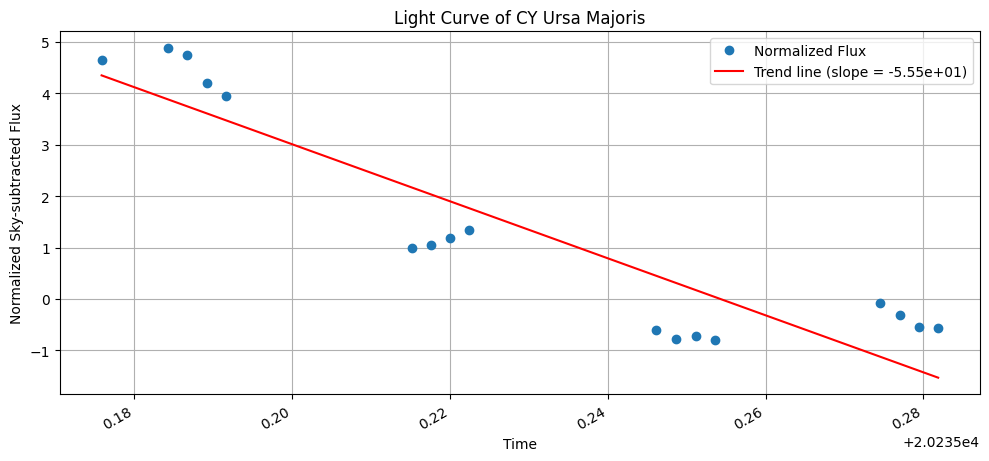

In [25]:
import os
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry

# Photometry Parameters
positions = [(513, 501)] ####Change to the (x, y) coordinates of target star####
aperture_radius = 8 ####Change to an approprite radius for target star####
sky_r_in = 13 ####Change to an appropriate radius for target star####
sky_annulus_width = 5

input_dir = 'May 27 Processed' ####Change to match the output directory above####
image_files = sorted([
    os.path.join(input_dir, f) for f in os.listdir(input_dir)
    if f.startswith("reduced_CY") and f.endswith(".fits") ####Change the startswith argument reduced_FITSFILES####
])


# Photometry Loop

time_series = []

for image_path in image_files:
    with fits.open(image_path) as hdul:
        data = hdul[0].data.astype(float)
        header = hdul[0].header

    # Extract time: prefer JD, fall back to DATE-OBS
    time = header.get("JD") or header.get("DATE-OBS")
    if time is None:
        continue  # Skip if no valid time

    # Set up apertures & perform photometry
    aperture = CircularAperture(positions, r=aperture_radius)
    annulus = CircularAnnulus(positions, r_in=sky_r_in, r_out=sky_r_in + sky_annulus_width)
    apers = [aperture, annulus]
    phot_table = aperture_photometry(data, apers)

    # Estimate and subtract sky background
    bkg_mean = phot_table['aperture_sum_1'] / annulus.area
    bkg_sum = bkg_mean * aperture.area
    net_flux = phot_table['aperture_sum_0'] - bkg_sum

    # Append result
    time_series.append({
        "filename": os.path.basename(image_path),
        "time": time,
        "flux": net_flux[0]
    })


# Convert times to astropy Time if in DATE-OBS string format
sample_time = time_series[0]["time"]
if isinstance(sample_time, str):
    times = Time([row["time"] for row in time_series], format='isot')
else:
    times = Time([row["time"] for row in time_series], format='jd')

fluxes = np.array([row["flux"] for row in time_series])
plot_times = times.plot_date

# Normalize fluxes & signma clip
median_flux = np.median(fluxes)
norm_flux = fluxes / median_flux

std_flux = np.std(norm_flux)
keep = np.abs(norm_flux - 1) < 3 * std_flux ####Change the multiplier of std_flux to desired value####

plot_times = plot_times[keep]
norm_flux = norm_flux[keep]


# Make trend line and plot
m, b = np.polyfit(plot_times, norm_flux, 1)
trend_line = m * plot_times + b

plt.figure(figsize=(10, 5))
plt.plot(plot_times, norm_flux, 'o', label="Normalized Flux", color='tab:blue')
plt.plot(plot_times, trend_line, '-', color='red', label=f"Trend line (slope = {m:.2e})")

plt.xlabel("Time")
plt.ylabel("Normalized Sky-subtracted Flux")
plt.title("Light Curve of CY Ursa Majoris") ####Change title####
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.gcf().autofmt_xdate()

plt.savefig("CYUma_light_curve_with_trend.png") ####Change to desired file name####
plt.show()
